In [19]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='once')
import warnings
warnings.simplefilter('ignore', category=FutureWarning)


(14392, 15)

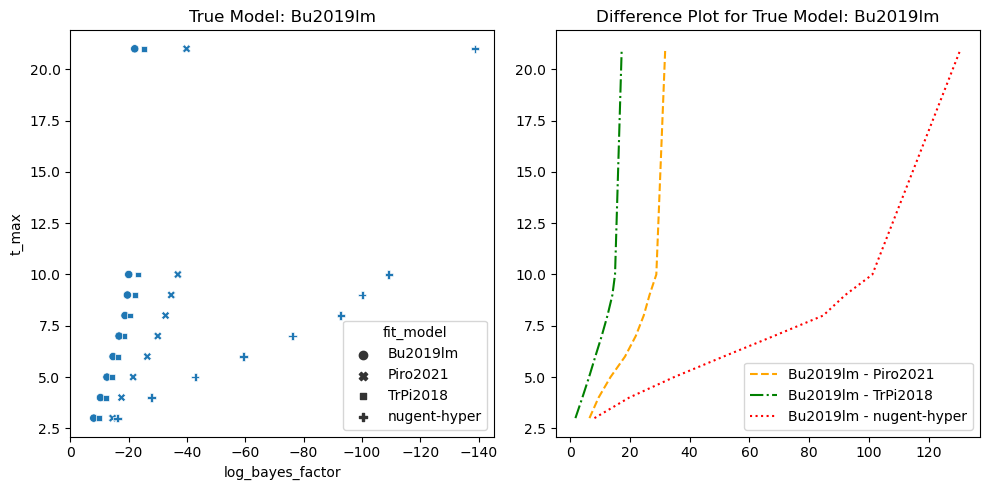

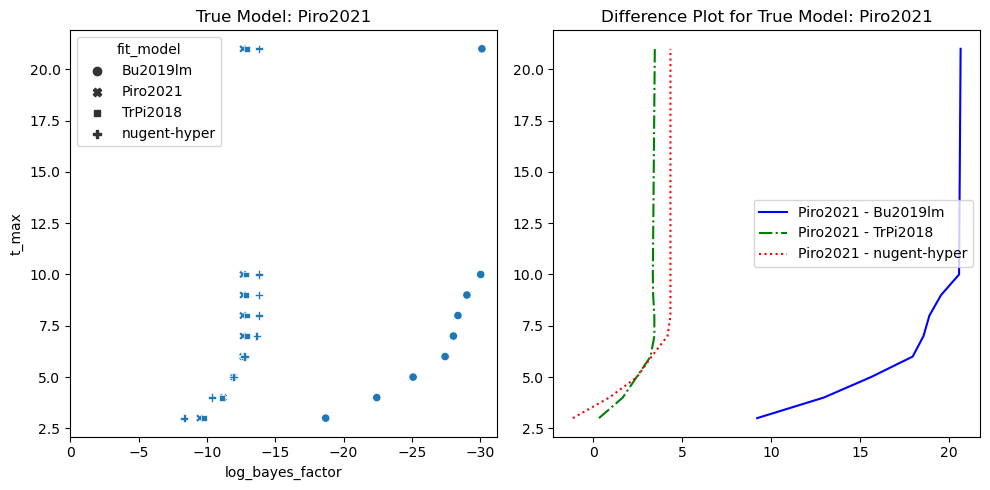

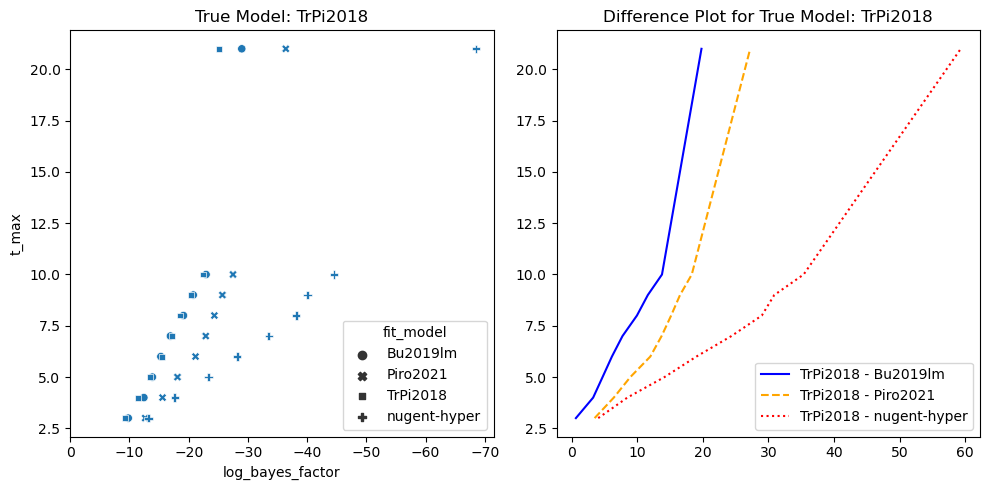

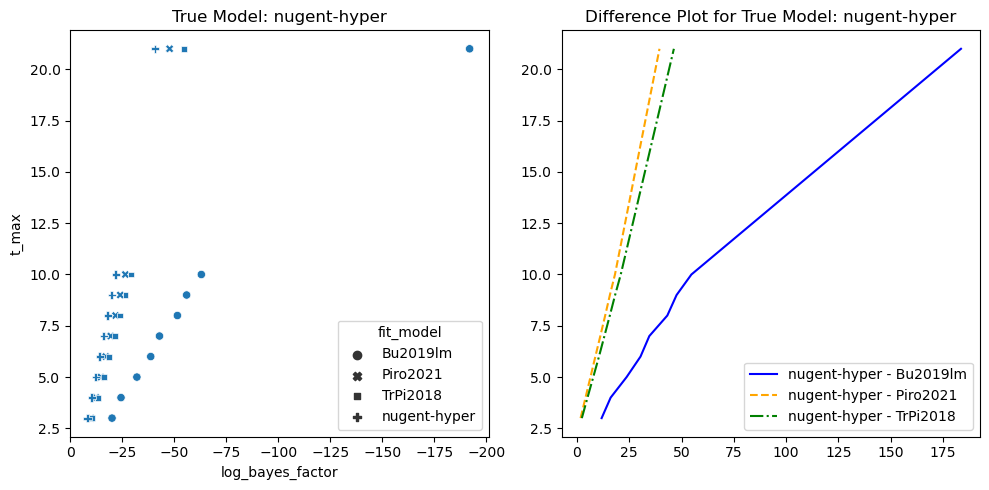

In [20]:
df = pd.read_csv('./model-recovery-validated_fit_df.csv')
df21 = pd.read_csv('./21-validation-fit_df.csv')
df = pd.concat([df, df21], ignore_index=True)

display(df.shape)
# display(df.head())

grouped_df = df.groupby(['t_max', 'fit_model', 'true_model']).agg({'log_bayes_factor': 'median'}).reset_index()
# display(grouped_df)
## dictionary of linestyles for each model (models are found in fit_model column)
ls_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['-', '--', '-.', ':'])}
color_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['blue', 'orange', 'green', 'red'])}

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for model in grouped_df['true_model'].unique():
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    ax0 = axs[0]
    iter_df = grouped_df[grouped_df['true_model'] == model]
    

    # # Calculate the mean and standard deviation of log_bayes_factor for each 't_max'
    # mean_log_bf = iter_df.groupby('t_max')['log_bayes_factor'].mean()
    # std_log_bf = iter_df.groupby('t_max')['log_bayes_factor'].std()
    
    # # Add error bars to the scatterplot for matching fit_model
    # for t_max in match_data['t_max'].unique():
    #     mean = mean_log_bf[t_max]
    #     std = std_log_bf[t_max]
    #     interval = std * 0.5  # One sigma

    #     data_for_t_max = match_data[match_data['t_max'] == t_max]
    #     ax0.errorbar(data_for_t_max['log_bayes_factor'], [t_max] * len(data_for_t_max),
    #                  xerr=interval, linestyle='None', color='black', capsize=3, capthick=1, alpha=0.5)

    sns.scatterplot(data=iter_df, x='log_bayes_factor', y='t_max',
                    style='fit_model', ax=ax0)
   
    


    ax0.set_title(f'True Model: {model}')
    ax0.invert_xaxis()
    ax0.set_xlim(0,)

    ax1 = axs[1]
    for fit_model in grouped_df['true_model'].unique():
        if fit_model != model:
            diff_df = grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == fit_model)]
            diff =(grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == model)]['log_bayes_factor'].values[0] - diff_df['log_bayes_factor'] )
            ax1.plot(diff, diff_df['t_max'], label=f'{model} - {fit_model}', linestyle=ls_dict[fit_model], color=color_dict[fit_model])

    ax1.set_title(f'Difference Plot for True Model: {model}')

    ax1.legend()

    plt.tight_layout()
    plt.show()

In [21]:

lowest_bayes = []
for lightcurve in  df['lightcurve'].unique():
    for tmax in df[df['lightcurve'] == lightcurve]['t_max'].unique():
        iterative_df = df[(df['lightcurve'] == lightcurve) & (df['t_max'] == tmax)]
        lowest_bf_row = iterative_df[iterative_df['log_bayes_factor'].abs() == iterative_df['log_bayes_factor'].abs().min()].squeeze()
        lowest_bayes.append(lowest_bf_row )

lbf_df = pd.DataFrame(lowest_bayes)     
# display(lbf_df)

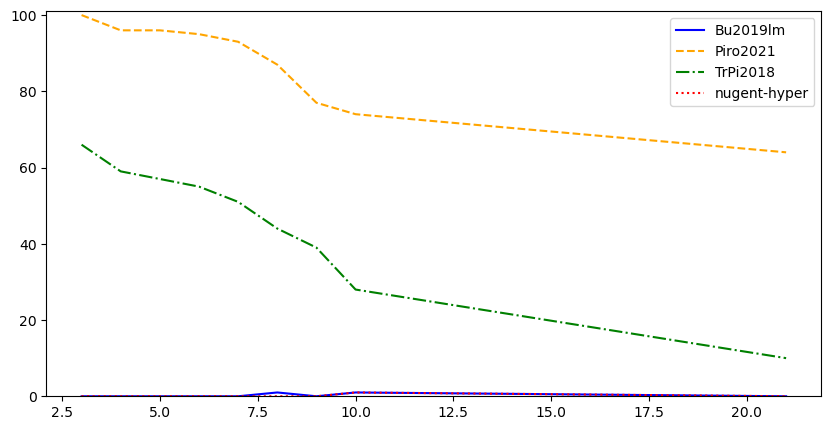

In [25]:
## plot the number of incorrect idenfications per model, grouped by t_max (x-axis)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for model in lbf_df['true_model'].unique():
    model_df = lbf_df[(lbf_df['true_model'] == model)]
    ## count number of incorrect identifications per t_max per model
    incorrect_identifications = []
    for tmax in sorted(model_df['t_max'].unique()):
        tmax_df = model_df[model_df['t_max'] == tmax]
        incorrect_identifications.append(len(tmax_df[tmax_df['fit_model'] != model]))
    ax.plot(sorted(model_df['t_max'].unique()), incorrect_identifications, label=model, linestyle=ls_dict[model], color=color_dict[model])
    ax.legend()
    ax.set_ylim(0, 101)
plt.show()


## from lbf_df, find percentage per model of incorrect identifications, grouped by t_max. there are 100 lightcurves for each model

# for tmax in sorted(lbf_df['t_max'].unique()):
#     print(f'\nFor t_max: {tmax}')
#     for model in lbf_df['true_model'].unique():
#         model_df = lbf_df[(lbf_df['true_model'] == model) & (lbf_df['t_max'] == tmax)]
#         print(f'For true model: {model}, the percentage of incorrect identifications is: {round(len(model_df[model_df["fit_model"] != model]) / len(model_df)*100,1)}')
        


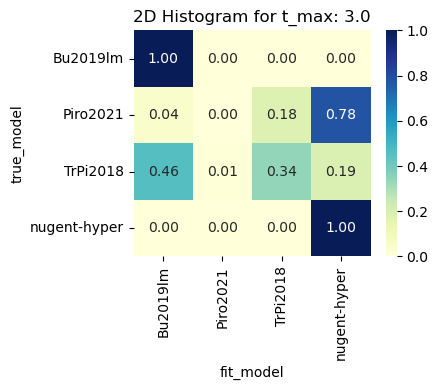

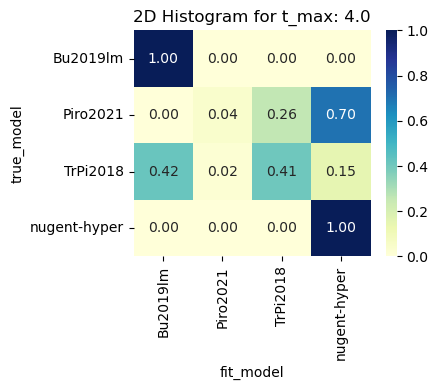

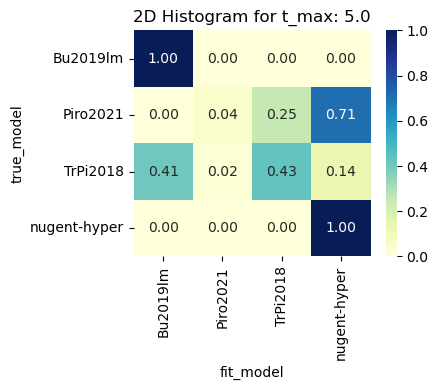

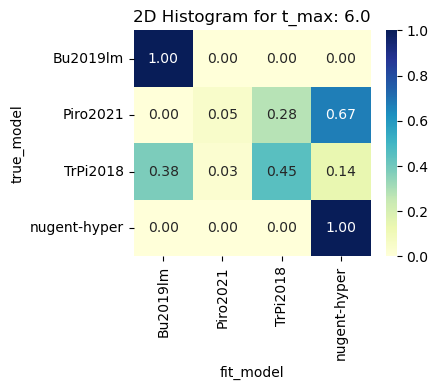

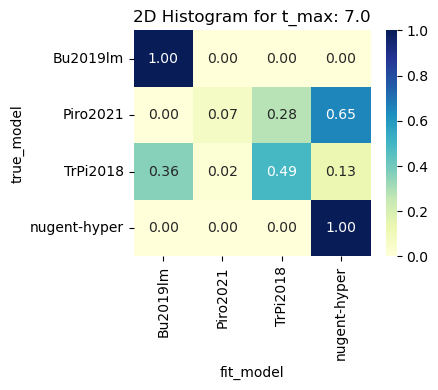

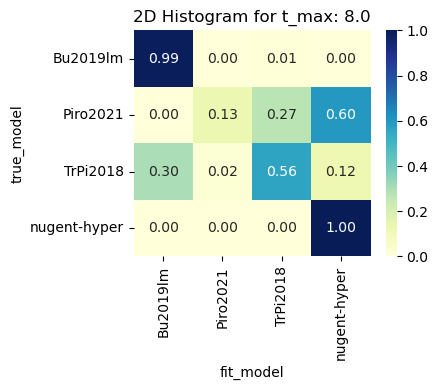

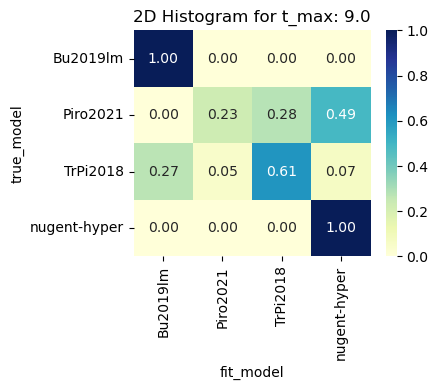

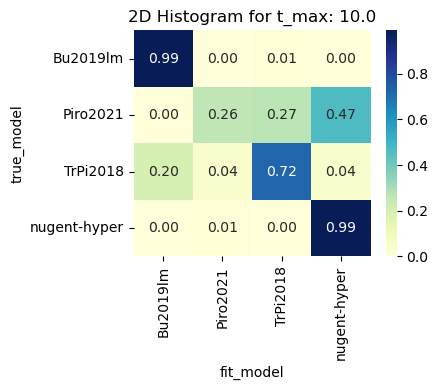

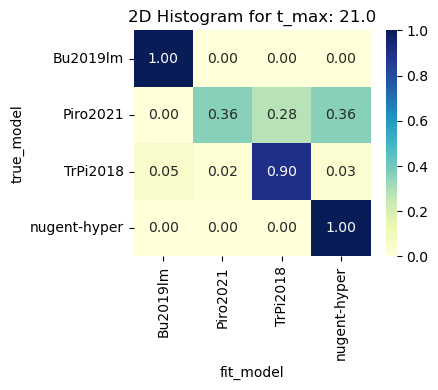

In [24]:
## for each lbf_df timestep, plot a 2d histogram of the true_mdodel vs fit_model
for tmax in sorted(lbf_df['t_max'].unique()):
    tmax_df = lbf_df[lbf_df['t_max'] == tmax]
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
    heatmap_data = tmax_df.groupby(['true_model', 'fit_model']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    ax.set_title(f'2D Histogram for t_max: {tmax}')
    fig.tight_layout()
    plt.show()

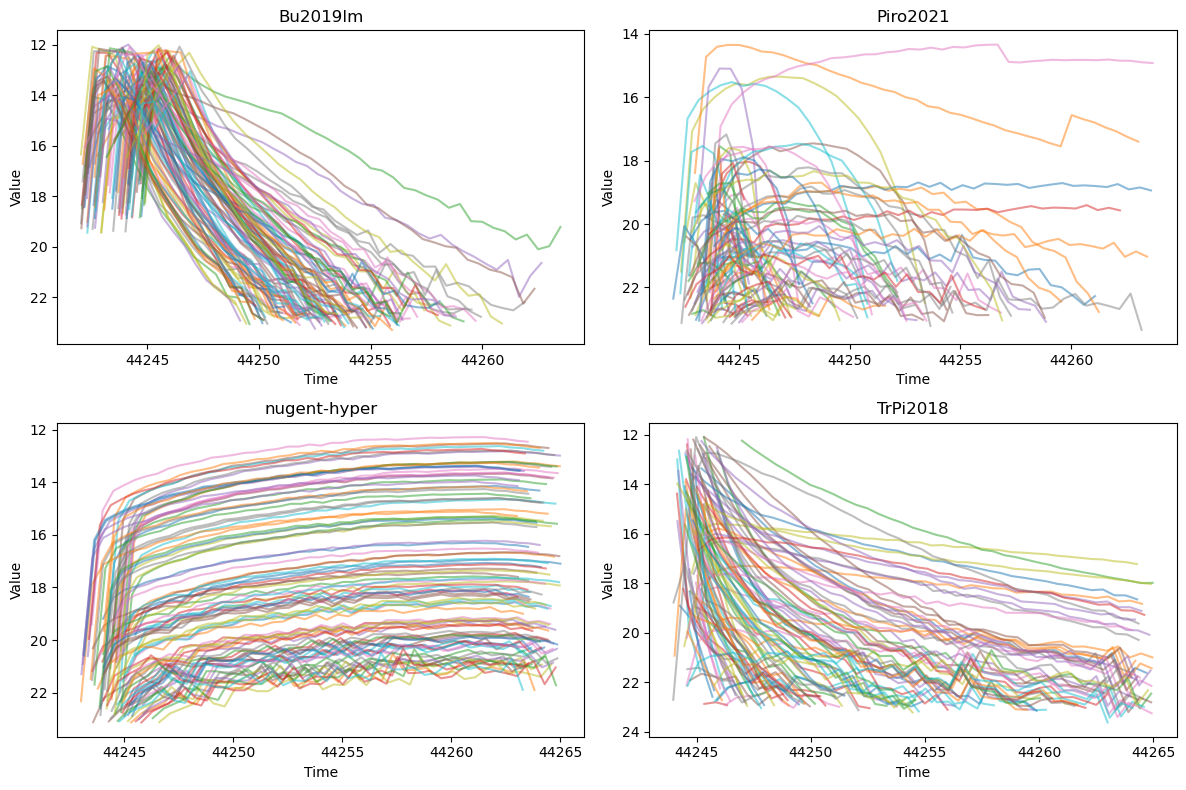

In [7]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = 'model-recovery-validated-injections'
model_data = {}

for filename in os.listdir(folder_path):
    if filename.startswith("lc_") and filename.endswith(".json"):
        model_name = filename.split("_")[1]
        with open(os.path.join(folder_path, filename), 'r') as file:
            data = json.load(file)
            ztfg_data = data.get("ztfg", [])

        if model_name not in model_data:
            model_data[model_name] = []
        model_data[model_name].append(ztfg_data)

plt.figure(figsize=(12, 8))

## Iterate through model data and plot each lightcurve as a separate line
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2  ## Determine the number of rows for subplots
for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = plt.subplot(rows, 2, i + 1)
    [sns.lineplot(data=pd.DataFrame(lc_data, columns=["Time", "Value", "Uncertainty"]), x="Time", y="Value", alpha=0.5) 
     for lc_data in lc_list]
    plt.title(model_name)
    plt.xlabel("Time")
    plt.ylabel("Value")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

Difference between Piro2021 injections when enforcing valid lightcurve generation

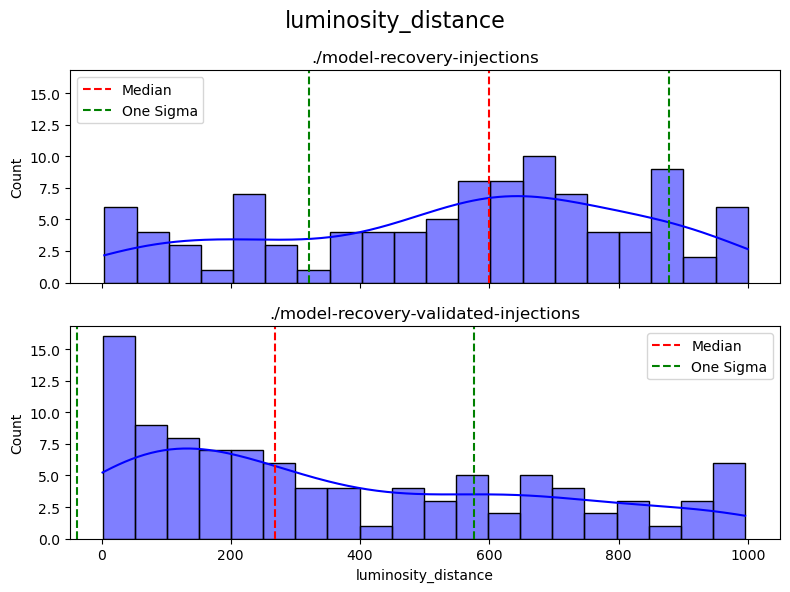

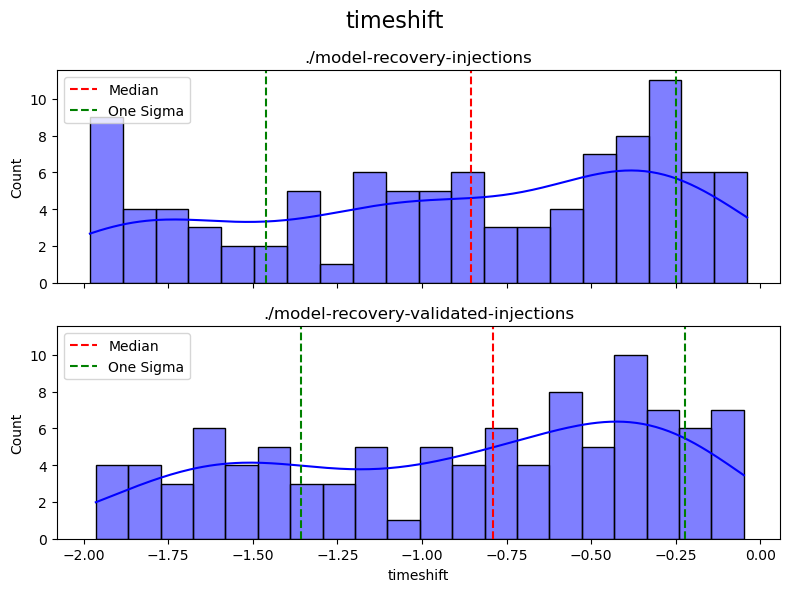

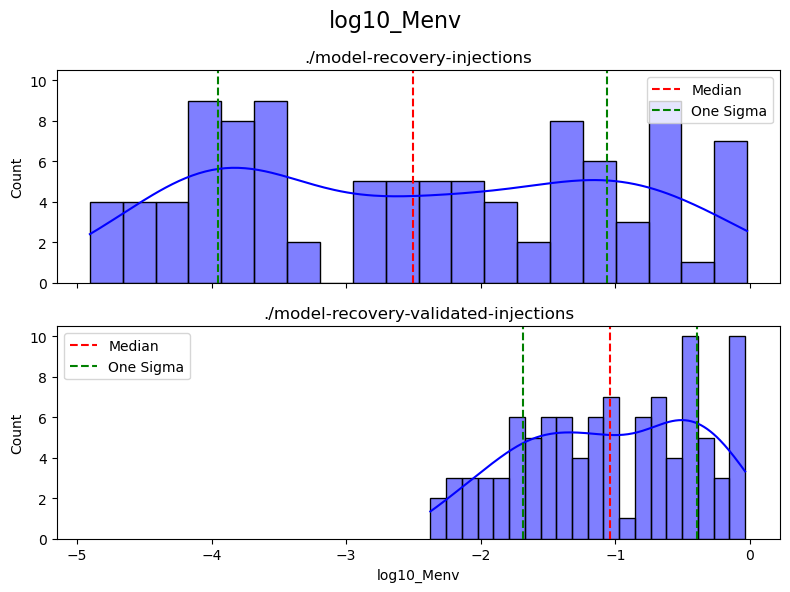

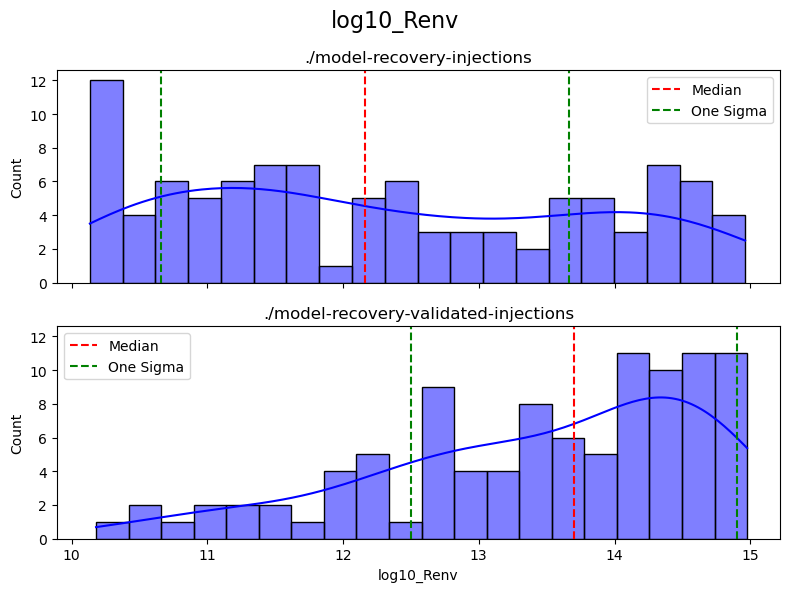

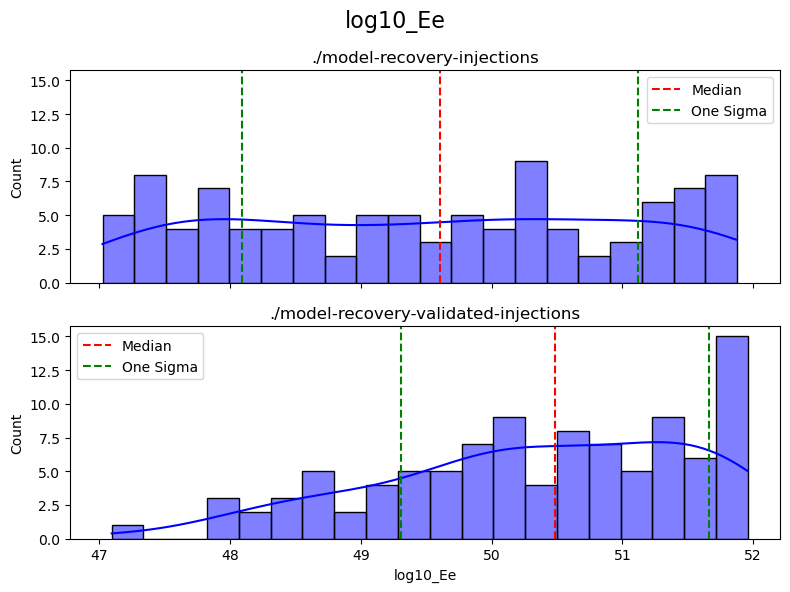

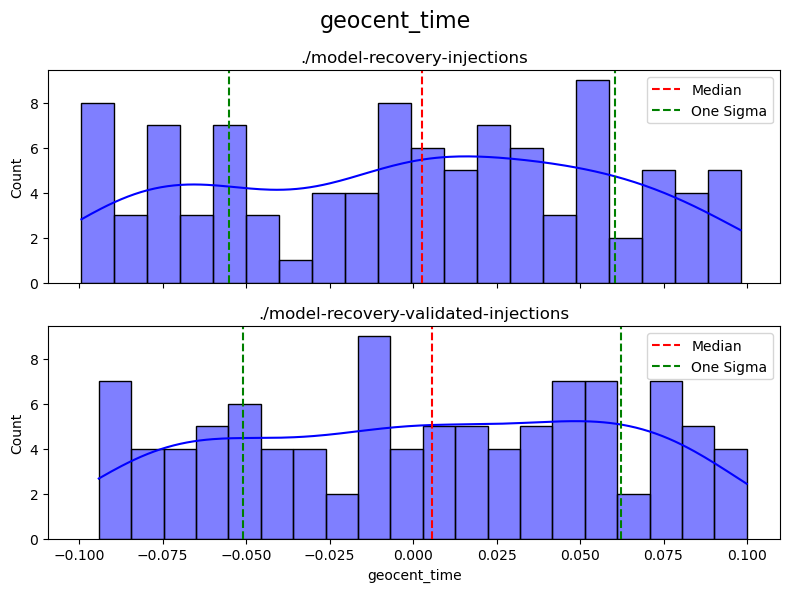

In [9]:
import os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the folder paths
folder_paths = ['./model-recovery-injections', './model-recovery-validated-injections']

# Initialize an empty list to store DataFrames
dfs = []

# Load DataFrames from the specified folders
for folder_path in folder_paths:
    data_list = []
    for filename in os.listdir(folder_path):
        if filename.startswith("inj_Piro2021_") and filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                json_data = json.load(file)
            content = json_data['injections']['content']
            for key, value in content.items():
                if len(value) == 1:
                    content[key] = value[0]
            data_list.append(content)
    df = pd.DataFrame(data_list)
    dfs.append(df)

# Create histograms for each column in both DataFrames
for i, column in enumerate(dfs[0].columns):
    if column.startswith('simulation_id'):
        continue
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle(column, fontsize=16)
    
    for j, df in enumerate(dfs):
        ax = axes[j]
        sns.histplot(df[column], kde=True, color='blue', bins=20, ax=ax)
        
        median = df[column].median()
        std = df[column].std()
        
        ax.axvline(median, color='red', linestyle='--', label='Median')
        ax.axvline(median - std, color='green', linestyle='--', label='One Sigma')
        ax.axvline(median + std, color='green', linestyle='--')
        
        # mu, std = norm.fit(df[column])
        
        # xmin, xmax = ax.get_xlim()
        # x = np.linspace(xmin, xmax, 100)
        # p = norm.pdf(x, mu, std)
        
        # ax.plot(x, p, 'k', linewidth=2, label='Fit')
        
        #ax.set_xlabel(f'{folder_paths[j]} - {column}')
        ax.set_title(f'{folder_paths[j]}')
        ax.legend()
    
    plt.tight_layout()

plt.show()


# for i, df in enumerate(dfs):
#     print(folder_paths[i])
#     display(df.describe())

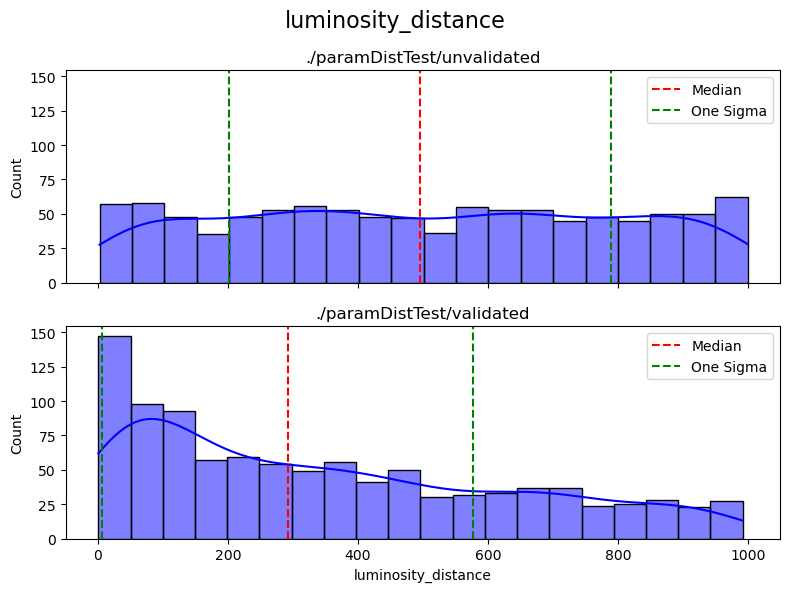

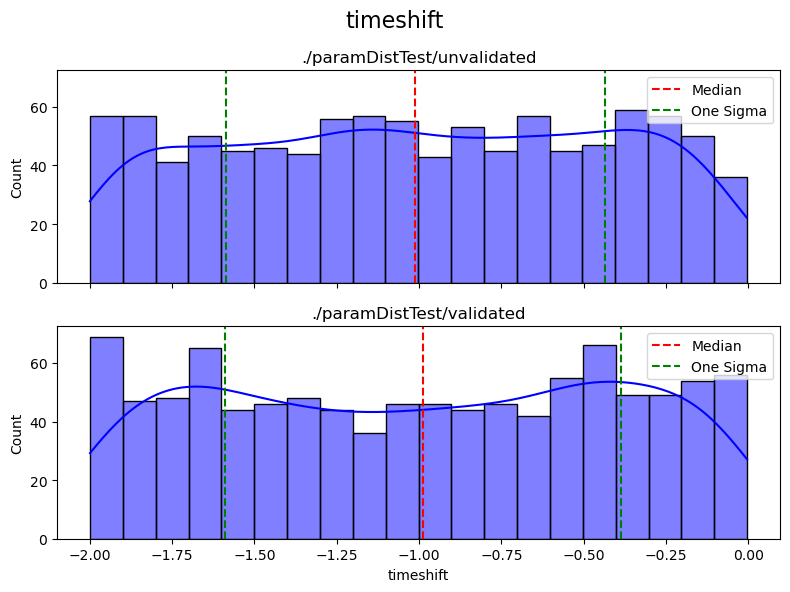

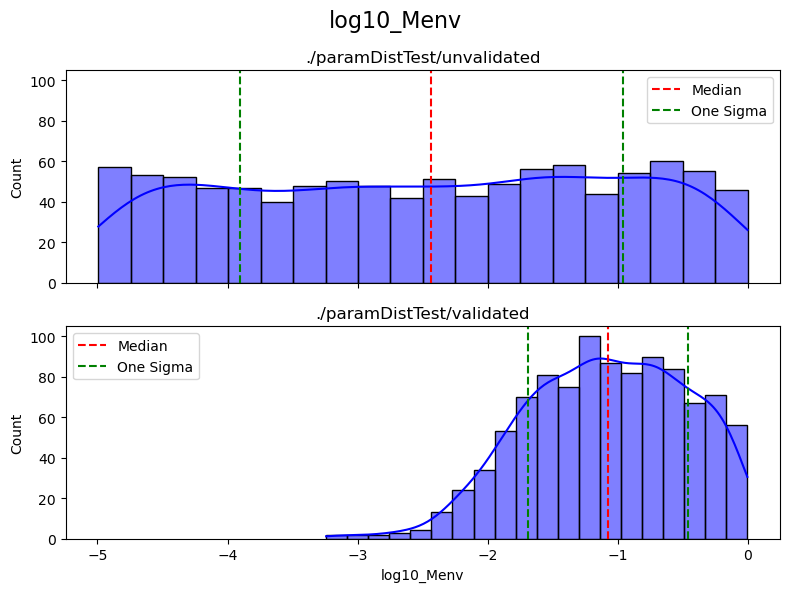

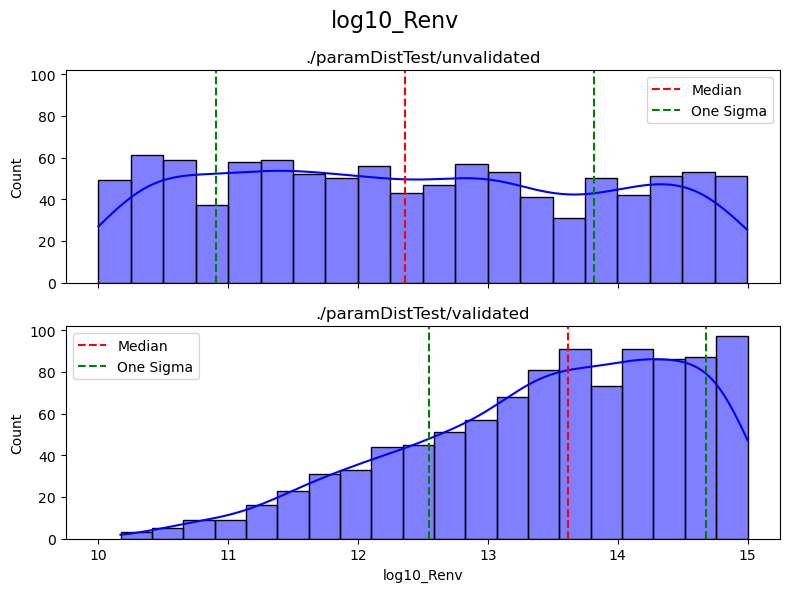

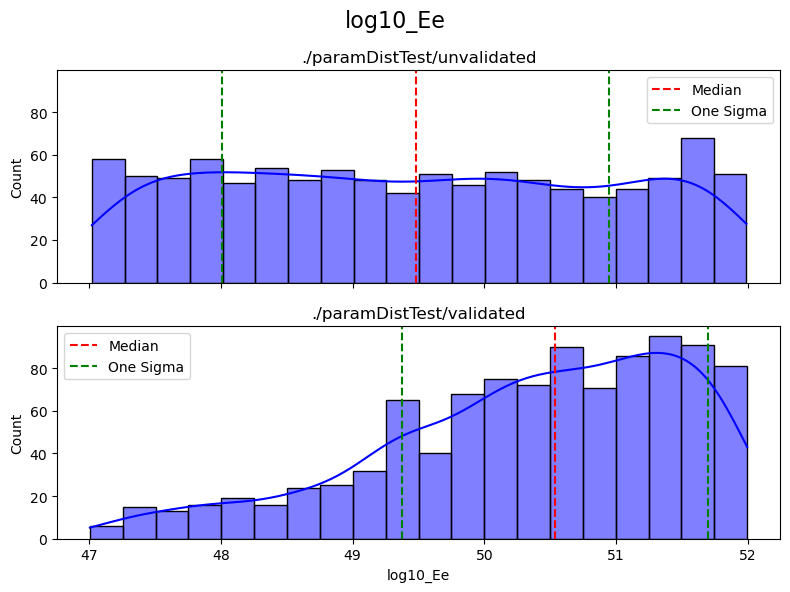

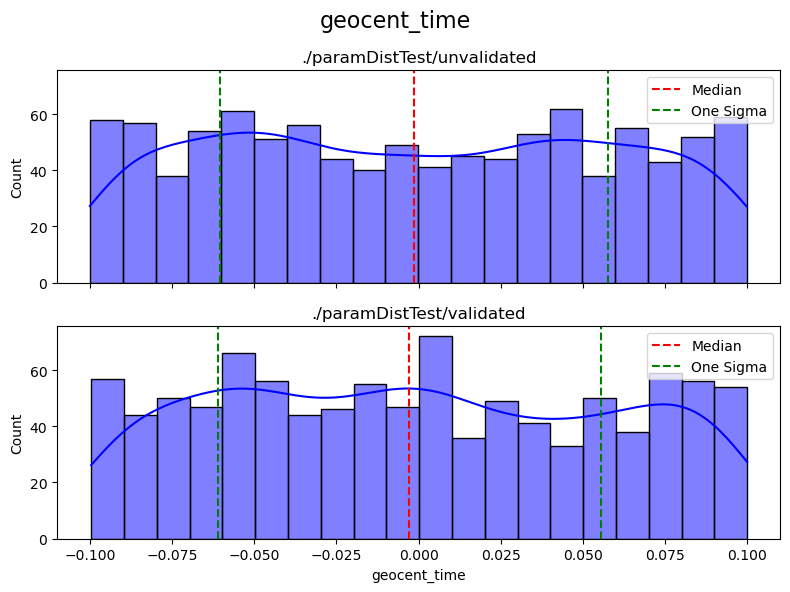

./paramDistTest/unvalidated


,simulation_id,luminosity_distance,timeshift,log10_Menv,log10_Renv,log10_Ee,geocent_time
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,501.932698,-1.008517,-2.474463,12.430318,49.482045,-0.000797
std,0.0,293.768573,0.574820,1.470843,1.454168,1.467247,0.059069
min,0.0,2.703534,-1.999172,-4.992974,10.002913,47.020371,-0.099958
25%,0.0,255.740752,-1.501171,-3.796972,11.168938,48.177443,-0.052633
50%,0.0,495.001012,-1.010793,-2.432807,12.359386,49.477050,-0.001384
75%,0.0,756.642150,-0.505555,-1.210565,13.705473,50.760109,0.048831
max,0.0,999.581978,-0.005370,-0.003601,14.996290,51.988888,0.099784


./paramDistTest/validated


,simulation_id,luminosity_distance,timeshift,log10_Menv,log10_Renv,log10_Ee,geocent_time
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,353.505119,-1.002106,-1.084190,13.459499,50.344238,-0.001229
std,0.0,284.971355,0.600681,0.614896,1.067816,1.161035,0.058381
min,0.0,0.743602,-1.998660,-3.242406,10.173281,47.005584,-0.099573
25%,0.0,102.137658,-1.552147,-1.531028,12.750252,49.576436,-0.051968
50%,0.0,291.821274,-0.987661,-1.072638,13.614725,50.538305,-0.002768
75%,0.0,569.393374,-0.469603,-0.598161,14.311434,51.277584,0.050749
max,0.0,991.932192,-0.003899,-0.005068,14.998754,51.994246,0.099926


In [7]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the folder paths
folder_paths = ['./paramDistTest/unvalidated', './paramDistTest/validated']

# Initialize an empty list to store DataFrames
dfs = []

# Load DataFrames from the specified folders
for folder_path in folder_paths:
    data_list = []
    for filename in os.listdir(folder_path):
        if filename.startswith("inj_Piro2021_") and filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                json_data = json.load(file)
            content = json_data['injections']['content']
            for key, value in content.items():
                if len(value) == 1:
                    content[key] = value[0]
            data_list.append(content)
    df = pd.DataFrame(data_list)
    dfs.append(df)

# Create histograms for each column in both DataFrames
for i, column in enumerate(dfs[0].columns):
    if column.startswith('simulation_id'):
        continue
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle(column, fontsize=16)
    
    for j, df in enumerate(dfs):
        ax = axes[j]
        sns.histplot(df[column], kde=True, color='blue', bins=20, ax=ax)
        
        median = df[column].median()
        std = df[column].std()
        
        ax.axvline(median, color='red', linestyle='--', label='Median')
        ax.axvline(median - std, color='green', linestyle='--', label='One Sigma')
        ax.axvline(median + std, color='green', linestyle='--')
        
        # mu, std = norm.fit(df[column])
        
        # xmin, xmax = ax.get_xlim()
        # x = np.linspace(xmin, xmax, 100)
        # p = norm.pdf(x, mu, std)
        
        # ax.plot(x, p, 'k', linewidth=2, label='Fit')
        
        #ax.set_xlabel(f'{folder_paths[j]} - {column}')
        ax.set_title(f'{folder_paths[j]}')
        ax.legend()
    
    plt.tight_layout()

plt.show()


# for i, df in enumerate(dfs):
#     print(folder_paths[i])
#     display(df.describe())